In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.datasets import california_housing

(inputs, targets), (x_test, y_test) = california_housing.load_data(version='small',test_split=0.2)
print(inputs.shape, targets.shape)
print(x_test.shape, y_test.shape)

(480, 8) (480,)
(120, 8) (120,)


### Extracting the sets for Training and validation

In [2]:
x_train = inputs[:380]
y_train = targets[:380]
x_val = inputs[380:]
y_val = targets[380:]

In [3]:
mean = x_train.mean(axis=0) # mean and standard deviation computed from training set only
std = x_train.std(axis=0)
x_train -= mean
x_train /= std
x_test -= mean
x_test /= std
x_val -= mean
x_val /= std
y_train /= 1e5
y_test /= 1e5
y_val /= 1e5

### Define the model architecture

In [4]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    Input(shape=(8,)),
    Dense(64, activation='relu'),
    Dropout(0.2),  # Add dropout to prevent overfitting
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

### configure the learning algorithm

In [5]:
model.compile(optimizer='adam',loss='mse',metrics=['mae'])

In [6]:
history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), verbose=0)

### Visual inspection of the values

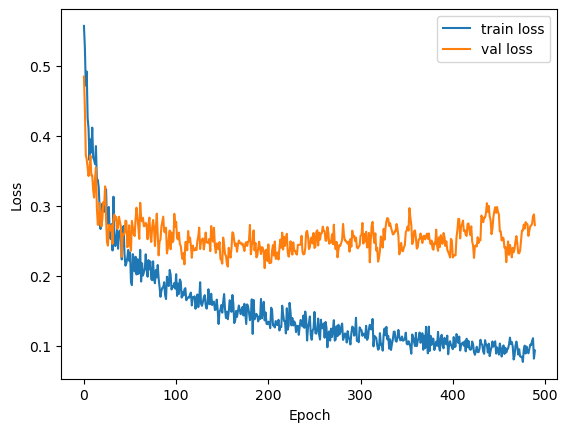

In [7]:
plt.plot(history.history['loss'][10:], label='train loss')
plt.plot(history.history['val_loss'][10:], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

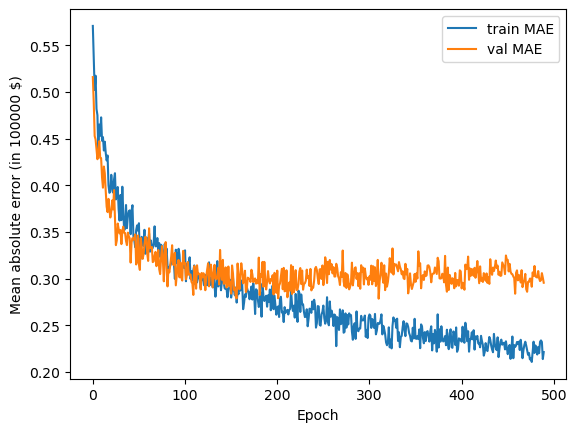

In [8]:
plt.plot(history.history['mae'][10:], label='train MAE')
plt.plot(history.history['val_mae'][10:], label='val MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error (in 100000 $)')
plt.show()

In [9]:
x_train_full = np.concatenate((x_train, x_val), axis=0)
y_train_full = np.concatenate((y_train, y_val), axis=0)

# Define and train the final model
model = Sequential([
    Input(shape=(8,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(x_train_full, y_train_full, epochs=100, batch_size=32, verbose=0)

In [10]:
# Evaluate the model
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test mean average error: {test_mae:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3205 - mae: 0.3284 
Test mean average error: 0.3194


In [11]:
from tensorflow.keras.losses import MeanAbsoluteError

y_pred_baseline = np.full_like(y_test, np.mean(y_train_full, axis=0))
mae_fn = MeanAbsoluteError()
mae_baseline = mae_fn(y_test, y_pred_baseline).numpy()
print(f'Mean baseline MAE: {mae_baseline:.4f}')

Mean baseline MAE: 0.8367
